<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/score_matching_swiss_roll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fit score-based  generative model to 2d swiss roll data.

Code is taken from
https://jax.readthedocs.io/en/latest/notebooks/score_matching.html

Notebook author: Denis Mazur, edited by Just Heuristic


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_swiss_roll


import jax
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.experimental import stax
from functools import partial

from IPython.display import clear_output

# Dataset

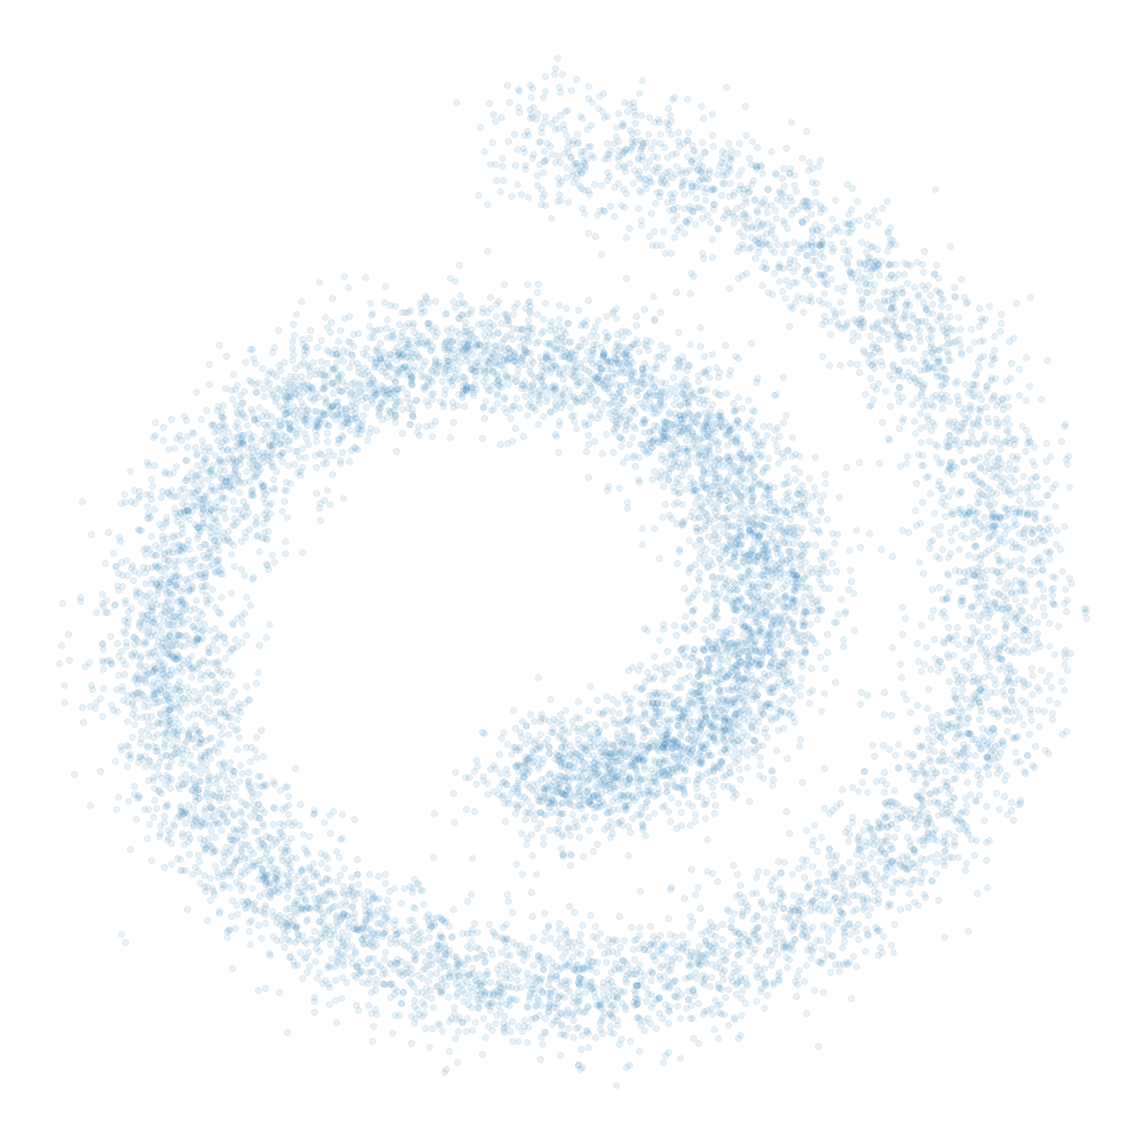

In [54]:
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    x = x[:, [0, 2]] / 10.0
    return np.array(x)

plt.figure(figsize=[16, 16])
plt.scatter(*sample_batch(10**4).T, alpha=0.1)
plt.axis('off')
plt.tight_layout()
plt.savefig('swiss_roll.png')

# Fit score function

In [4]:

# Set up network to predict scores
net_init, net_apply = stax.serial(
    stax.Dense(128), stax.Softplus,
    stax.Dense(128), stax.Softplus,
    stax.Dense(2),
)

# Create optimizer. Note that both network and optimizer returns pure (stateless) functions
opt_init, opt_update, get_params = optimizers.adam(1e-3)

In [23]:
@jax.jit
def compute_loss(net_params, inputs):
    #  a function that computes jacobian by forward mode differentiation
    jacobian = jax.jacfwd(net_apply, argnums=-1)
    
    # we use jax.vmap to vectorize jacobian function along batch dimension
    batch_jacobian = jax.vmap(partial(jacobian, net_params))(inputs)  # [batch, dim, dim]
    
    trace_jacobian = jnp.trace(batch_jacobian, axis1=1, axis2=2)
    output_norm_sq = jnp.square(net_apply(net_params, inputs)).sum(axis=1)
    
    return jnp.mean(trace_jacobian + 1/2 * output_norm_sq)


@jax.jit
def train_step(step_i, opt_state, batch, key):
    net_params = get_params(opt_state)
    loss = compute_loss(net_params, batch)
    grads = jax.grad(compute_loss, argnums=0)(net_params, batch)
    return loss, opt_update(step_i, grads, opt_state)

In [26]:
def train_loop(key, train_step, nsteps):
  key, subkey = jax.random.split(key)
  out_shape, net_params = net_init(subkey, input_shape=(-1, 2))
  opt_state = opt_init(net_params)
  loss_history = []
  for i in range(nsteps):
      x = sample_batch(size=128)
      key, subkey = jax.random.split(key)
      loss, opt_state = train_step(i, opt_state, x, subkey)
      loss_history.append(loss.item())
      if i % 200 == 0:
          clear_output(True)
          plt.figure(figsize=[16, 8])
          plt.subplot(1, 2, 1)
          plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
          plt.scatter(jnp.arange(len(loss_history)), loss_history)
          plt.grid()
          
          plt.subplot(1, 2, 2)
          net_params = get_params(opt_state)
          xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 2.0, 50), jnp.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
          scores = net_apply(net_params, xx)
          scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
          scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

          plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
          plt.xlim(-1.5, 2.0)
          plt.ylim(-1.5, 2.0)
          plt.show()

  return opt_state

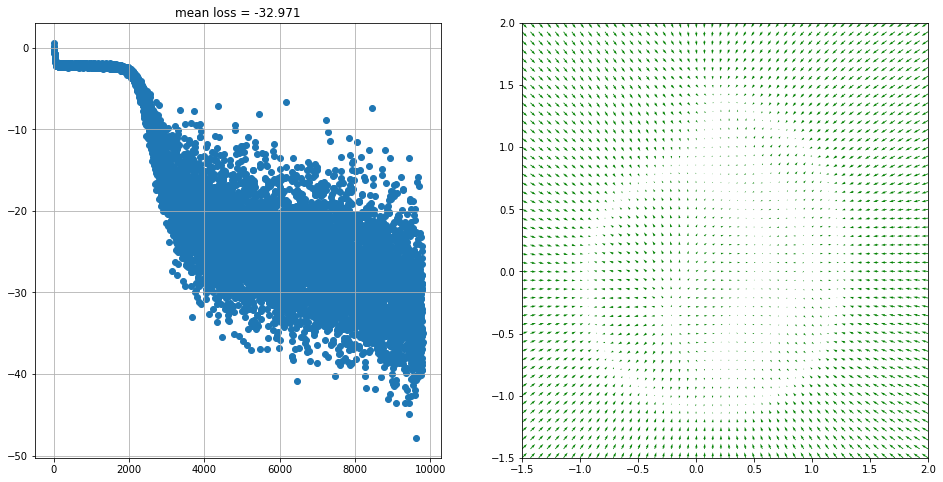

In [28]:
opt_state = train_loop(jax.random.PRNGKey(seed=42), train_step, 10000)

In [31]:
opt_state_basic = opt_state

# Plot gradient field

In [55]:
opt_state = opt_state_basic

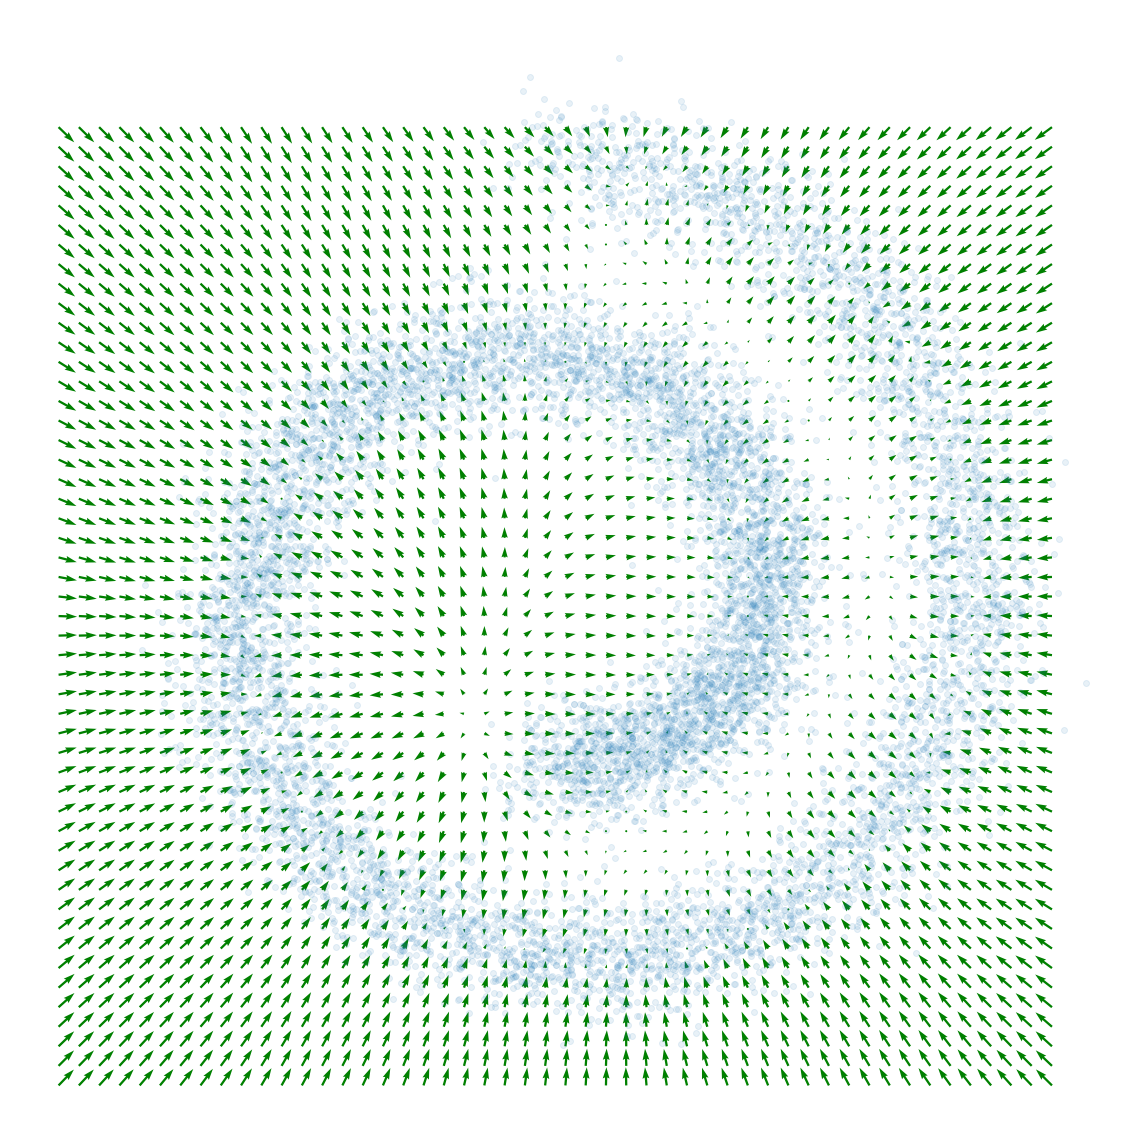

In [56]:
plt.figure(figsize=[16, 16])

net_params = get_params(opt_state)
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis('off')
plt.tight_layout()
plt.savefig('score_matching_swiss_roll.png')

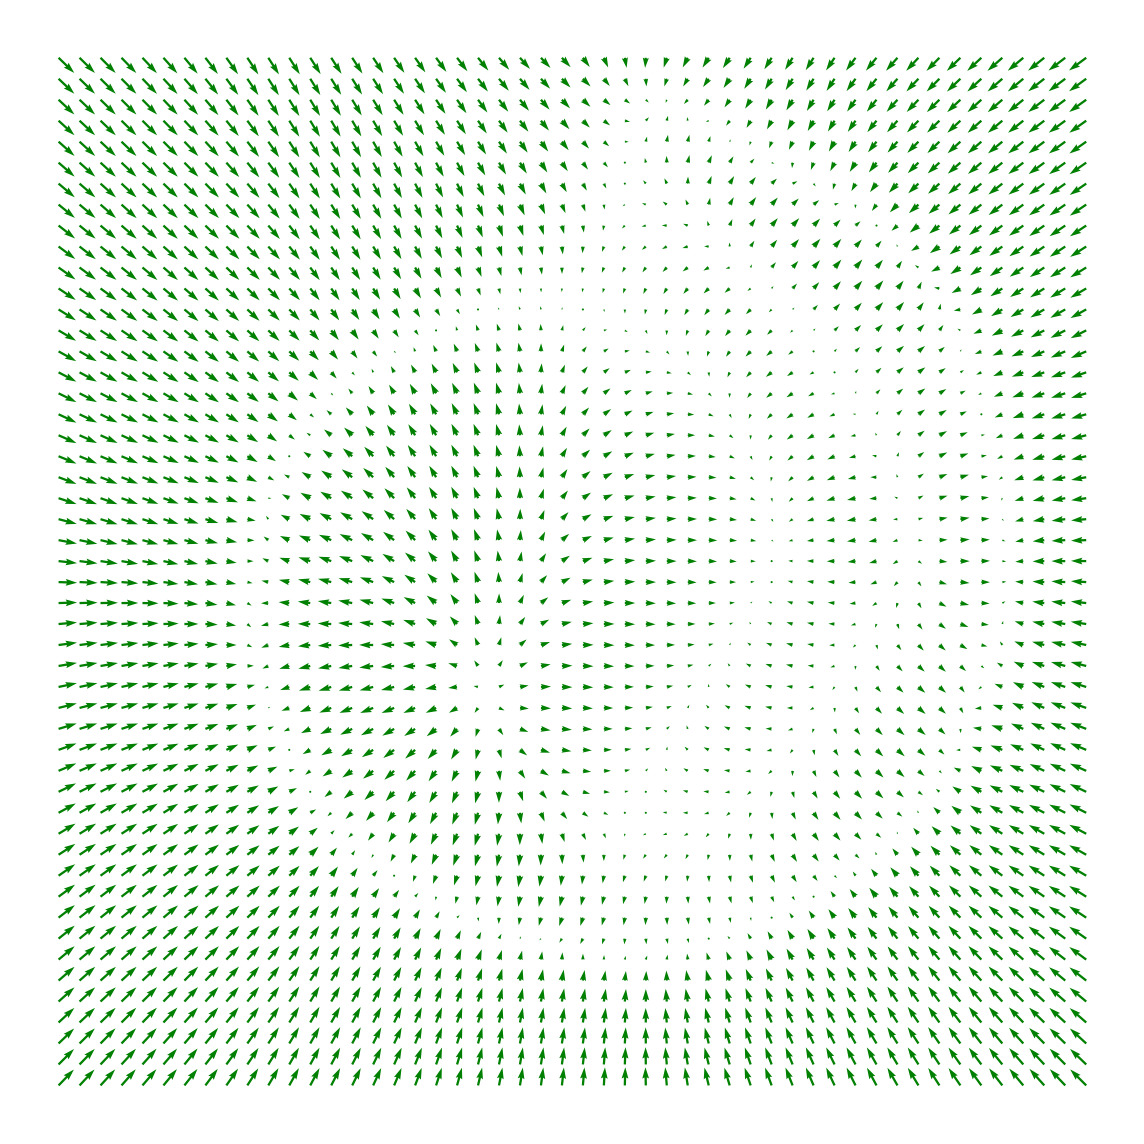

In [57]:
plt.figure(figsize=[16, 16])

net_params = get_params(opt_state)
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
#plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis('off')
plt.tight_layout()
plt.savefig('score_matching_swiss_roll_no_data.png')

# Fit using sliced score matching

In [34]:
@jax.jit
def compute_ssm_loss(net_params, inputs, key):
    apply = jax.jit(partial(net_apply, net_params))
    batch_dot = partial(jnp.einsum, 'bu,bu->b')
    
    # generate random vectors from N(0, I)
    v = jax.random.normal(key, shape=inputs.shape)

    # predict score and compute jacobian of score times v
    score, jac_v = jax.jvp(apply, [inputs], [v])
    
    return jnp.mean(batch_dot(v, jac_v) + 1/2 * batch_dot(v, score) ** 2)

@jax.jit
def train_step(step_i, opt_state, batch, key):
    # the new compute_loss is random key dependent, thus we need a new train_step function
    net_params = get_params(opt_state)
    loss = compute_ssm_loss(net_params, batch, key)
    grads = jax.grad(compute_ssm_loss, argnums=0)(net_params, batch, key)
    return loss, opt_update(step_i, grads, opt_state)

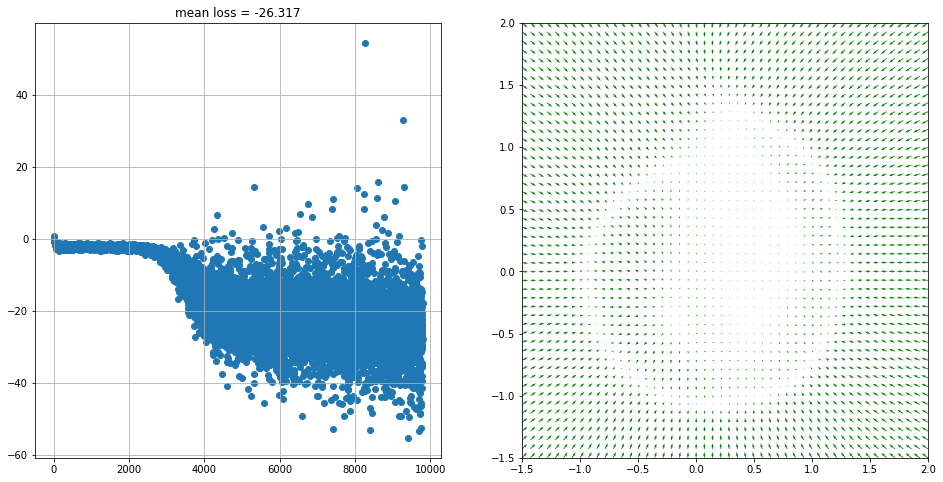

In [35]:
opt_state = train_loop(jax.random.PRNGKey(seed=42), train_step, 10000)

In [36]:
opt_state_sliced = opt_state

# Plot gradient field

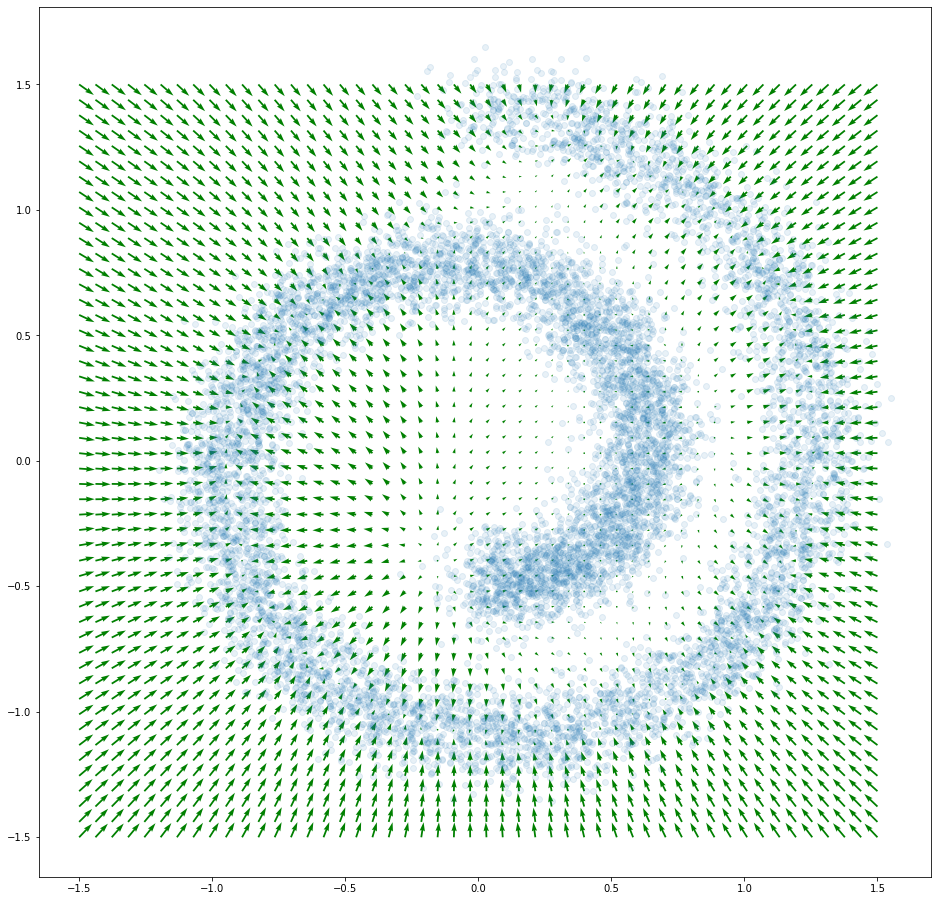

In [37]:
plt.figure(figsize=[16, 16])

net_params = get_params(opt_state)
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.savefig('score_matching_sliced_swiss_roll.pdf', dpi=300)

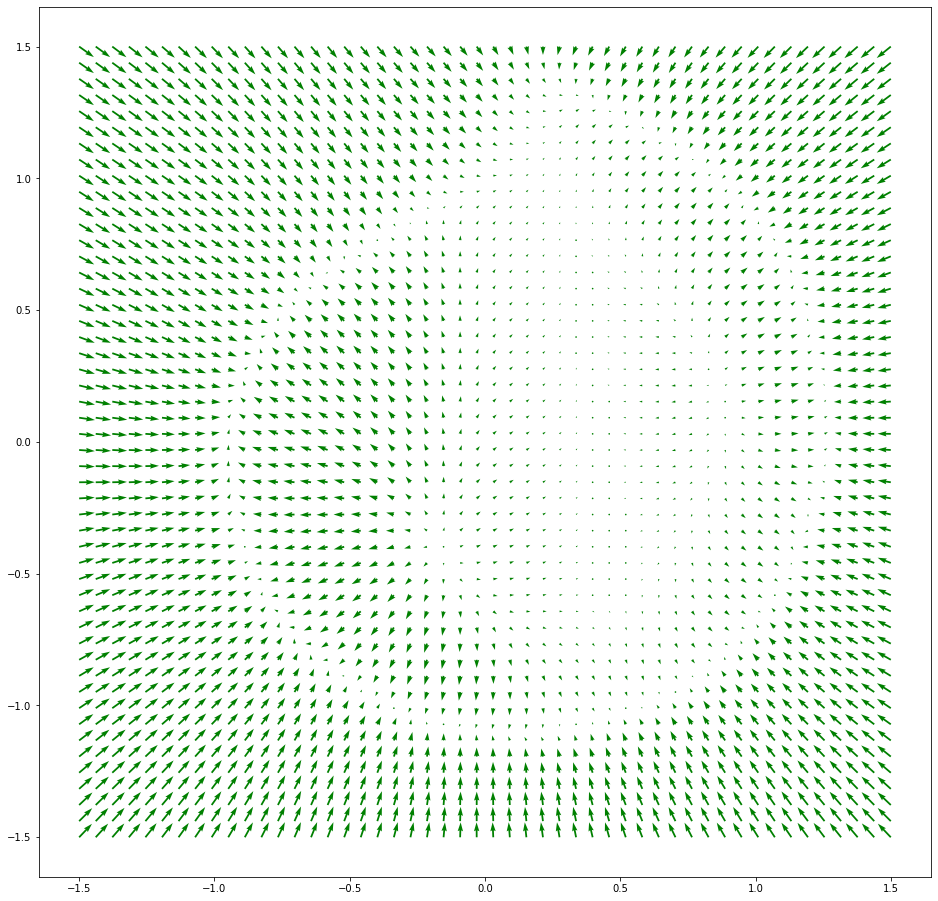

In [38]:
plt.figure(figsize=[16, 16])

net_params = get_params(opt_state)
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
#plt.scatter(*sample_batch(10_000).T, alpha=0.1)


# Langevin sampling

In [45]:
def sample_langevin(x_initial, *, net_params, key, eps=1e-2, eps_decay=0.9, num_steps=15, temperature=1.0):
    """ sample x ~ p(x) by applying approximate Langvenin Dynamics, return a sequence of x_t """
    x_t, x_sequence = x_initial, [x_initial]
    
    for t in range(num_steps):
        key, subkey = jax.random.split(key)
        z_t = jax.random.normal(subkey, shape=x_t.shape)
        x_t = x_t + eps / 2 * net_apply(net_params, x_t) + jnp.sqrt(eps) * temperature * z_t
        x_sequence.append(x_t)
        eps *= eps_decay
        
    return jnp.stack(x_sequence)

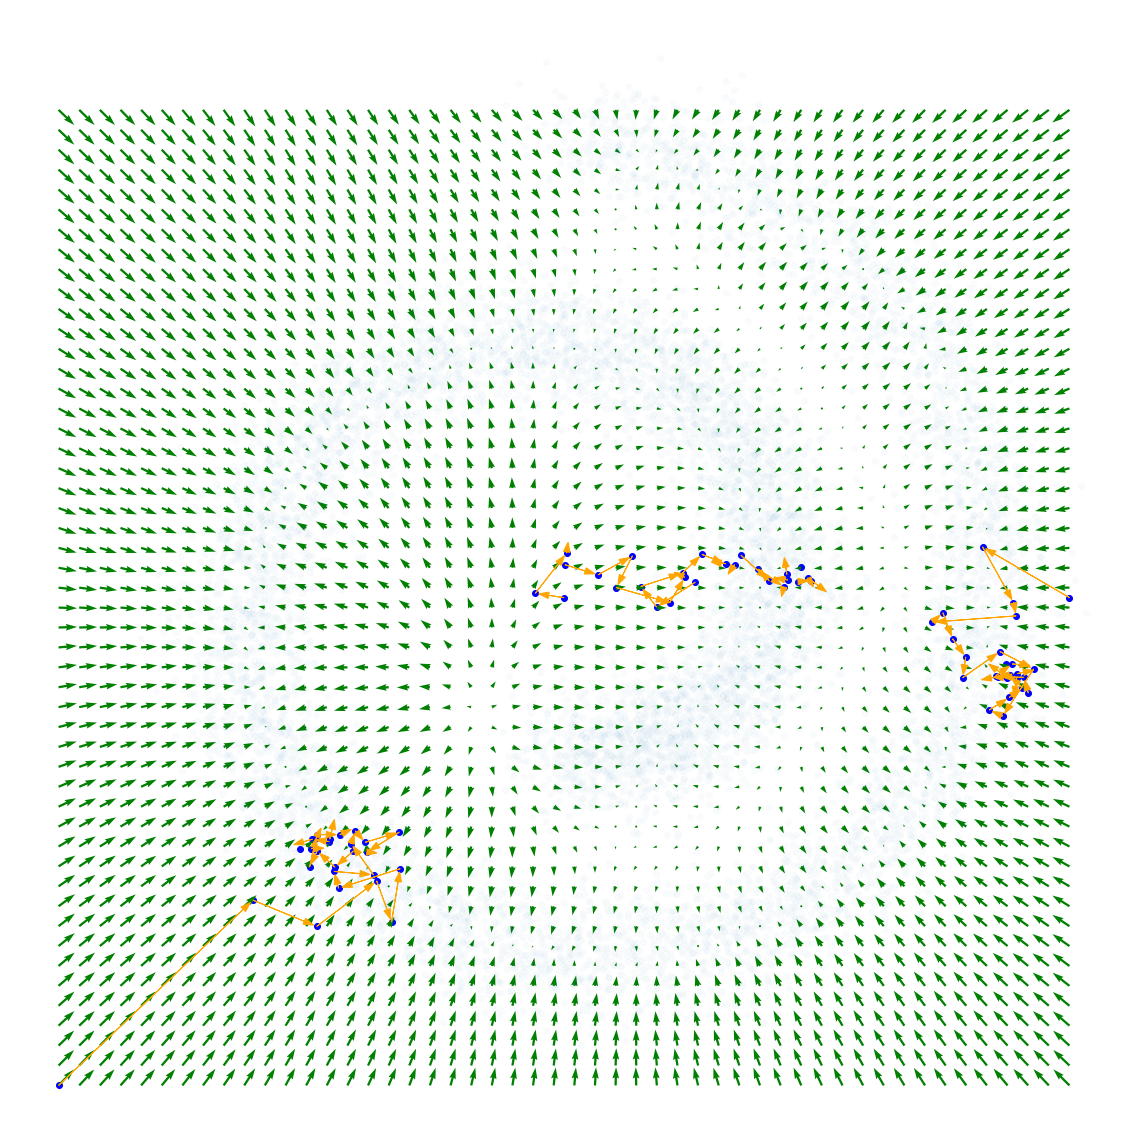

In [58]:
plt.figure(figsize=[16, 16])

key = jax.random.PRNGKey(42)
net_params = get_params(opt_state)

for x_initial in jnp.array([[-1.5, -1.5], [0, 0], [1.5, 0]]):
    key, subkey = jax.random.split(key)
    # sample x sequence
    xx = sample_langevin(x_initial, key=subkey, net_params=net_params, num_steps=25)
    plt.scatter(xx.T[0], xx.T[1], color="blue")

    # draw arrows for each mcmc step
    deltas = (xx[1:] - xx[:-1])
    deltas = deltas - deltas / jnp.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(xx[i][0], xx[i][1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="orange")
    
# plot data points and gradients
plt.plot()
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
plt.axis('off')
plt.scatter(*sample_batch(10_000).T, alpha=0.025)
plt.tight_layout()
plt.savefig('langevin_swiss_roll.png')
plt.show()

<Figure size 432x288 with 0 Axes>